# Desafio Descubra quem fez o ENEM 2016 apenas para treino


__Detalhes__

Neste desafio deverá descobrir quais estudantes estão fazendo a prova apenas para treino.

O contexto do desafio gira em torno dos resultados do ENEM 2016 (disponíveis no arquivo train.csv). Este arquivo, e apenas ele, deve ser utilizado para todos os desafios. Qualquer dúvida a respeito das colunas, consulte o Dicionário dos Microdados do Enem 2016.

Alguns estudantes decidem realizar prova do ENEM de forma precoce, como um teste (coluna IN_TREINEIRO). Neste desafio, você deve criar um modelo de classificação binária para inferir a mesma. Os resultados possíveis da sua resposta devem ser “0” ou “1”.

Salve sua resposta em um arquivo chamado answer.csv com duas colunas: NU_INSCRICAO e IN_TREINEIRO.

## Importação das bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [2]:
# Algumas configurações para o matplotlib.
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 12)

__Importação banco de dados__

In [3]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

In [4]:
data_train.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


In [5]:
data_test.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,43,RS,19,F,1,1,1,3,1,...,NaN,NaN,E,E,H,B,B,C,D,A
1,177f281c68fa032aedbd842a745da68490926cd2,15,PA,24,M,3,2,1,4,1,...,NaN,NaN,B,C,B,A,A,C,D,A
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,29,BA,16,F,2,1,3,0,1,...,NaN,NaN,E,F,G,B,B,A,NaN,D
3,5c356d810fa57671402502cd0933e5601a2ebf1e,41,PR,17,F,1,1,2,0,2,...,40.0,480.0,E,E,E,C,B,B,C,A
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,53,DF,19,F,1,1,1,1,1,...,80.0,720.0,E,E,E,B,B,B,D,A


__Limpeza inicial dos bancos de dados__

In [6]:
# Removendo dados do treino que não possuem no teste.
# Criar coluna IN_TREINEIRO para os dados de teste
data_test['IN_TREINEIRO'] = 0
    
# Remover as colunas do data_train que não existem no data_test
colunas_train = data_train.columns  # Colunas do data frame de treino
colunas_test = data_test.columns    # Colunas do data frame de teste

for i in range(len(colunas_train)):
    for j in range(len(colunas_test)): 
        if (colunas_train[i] == colunas_test[j]):
            remove_coluna = False
            break
        else:
            remove_coluna = True
    if remove_coluna:
        del data_train[colunas_train[i]]  # Comando para excluir colunas de DF

## Análise dos dados

In [7]:
# Criando um dataframe auxiliar para analisar a consistência das variáveis do data_train
df_auxiliar_train = pd.DataFrame({'colunas' : data_train.columns,
                    'tipo': data_train.dtypes,
                    'missing' : data_train.isna().sum(),
                    'size' : data_train.shape[0],
                    'unicos': data_train.nunique()})
df_auxiliar_train['percentual faltante [%]'] = 100*round(df_auxiliar_train['missing'] / df_auxiliar_train['size'],2)
df_auxiliar_train

,colunas,tipo,missing,size,unicos,percentual faltante [%]
NU_INSCRICAO,NU_INSCRICAO,object,0,13730,13730,0.0
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,0,13730,27,0.0
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,13730,27,0.0
NU_IDADE,NU_IDADE,int64,0,13730,55,0.0
TP_SEXO,TP_SEXO,object,0,13730,2,0.0
TP_COR_RACA,TP_COR_RACA,int64,0,13730,6,0.0
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,0,13730,5,0.0
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,0,13730,4,0.0
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,0,13730,11,0.0
TP_ESCOLA,TP_ESCOLA,int64,0,13730,4,0.0


In [8]:
# Criando um dataframe auxiliar para analisar a consistência das variáveis do data_test
df_auxiliar_test = pd.DataFrame({'colunas' : data_test.columns,
                    'tipo': data_test.dtypes,
                    'missing' : data_test.isna().sum(),
                    'size' : data_test.shape[0],
                    'unicos': data_test.nunique()})
df_auxiliar_test['percentual faltante [%]'] = 100*round(df_auxiliar_test['missing'] / df_auxiliar_test['size'],2)
df_auxiliar_test

,colunas,tipo,missing,size,unicos,percentual faltante [%]
NU_INSCRICAO,NU_INSCRICAO,object,0,4570,4570,0.0
CO_UF_RESIDENCIA,CO_UF_RESIDENCIA,int64,0,4570,27,0.0
SG_UF_RESIDENCIA,SG_UF_RESIDENCIA,object,0,4570,27,0.0
NU_IDADE,NU_IDADE,int64,0,4570,47,0.0
TP_SEXO,TP_SEXO,object,0,4570,2,0.0
TP_COR_RACA,TP_COR_RACA,int64,0,4570,6,0.0
TP_NACIONALIDADE,TP_NACIONALIDADE,int64,0,4570,5,0.0
TP_ST_CONCLUSAO,TP_ST_CONCLUSAO,int64,0,4570,4,0.0
TP_ANO_CONCLUIU,TP_ANO_CONCLUIU,int64,0,4570,11,0.0
TP_ESCOLA,TP_ESCOLA,int64,0,4570,4,0.0


Percebe-se que a coluna NU_INSCRICAO não terá utilidade no modelo, uma vez que tem valor único para cada candidato. Dessa forma, remove-se tal coluna dos dados, mantendo apenas em um data frame answer para fins de resposta do desafio.

In [9]:
# A resposta será montada com o número de inscrição e o Indicador se era Treineiro
answer= data_test[['NU_INSCRICAO', 'IN_TREINEIRO']]

__Retirar do banco variáveis não numéricas__

In [10]:
colunas_numericas  = list((df_auxiliar_train[df_auxiliar_train['tipo'] != 'object'])['colunas'])

In [11]:
data_train = data_train[colunas_numericas]

In [12]:
data_test = data_test[colunas_numericas]

## Dados Faltantes

__Remover as colunas TP_ENSINO e TP_DEPENDENCIA_ADM_ESC por ter muitos dados faltantes__

In [13]:
data_train.drop('TP_ENSINO', axis=1, inplace = True)
data_train.drop('TP_DEPENDENCIA_ADM_ESC', axis=1, inplace = True)

In [14]:
data_test.drop('TP_ENSINO', axis=1, inplace = True)
data_test.drop('TP_DEPENDENCIA_ADM_ESC', axis=1, inplace = True)

Percebe-se que só restam dados faltantes nas colunas relativas às notas. Dessa forma, provavelmente os dados faltantes indicam os candidatos que faltaram a prova. Uma boa alternativa nesse caso, é substituir a nota dos candidatos que faltaram a prova por -1000, por ser uma nota inatingível.

In [15]:
data_train.fillna(-1000, inplace = True)
data_test.fillna(-1000, inplace = True)

In [16]:
data_train.isnull().sum().sum()

0

In [17]:
data_test.isnull().sum().sum()

0

# Dados desbalanceados

Utilizar o SMOTE para reamostrar os dados da classe minoritária (Oversampling).

In [18]:
data_train['IN_TREINEIRO'].value_counts()

0    11947
1     1783
Name: IN_TREINEIRO, dtype: int64

In [19]:
# Testando PCA com 25 componentes (há 30 variáveis disponíveis)
pca = PCA(n_components=25)
X_train = data_train.drop(['IN_TREINEIRO'], axis=1)
Y_train = data_train['IN_TREINEIRO']                         
pca.fit(X_train)

X_train_pca = pca.transform(X_train)

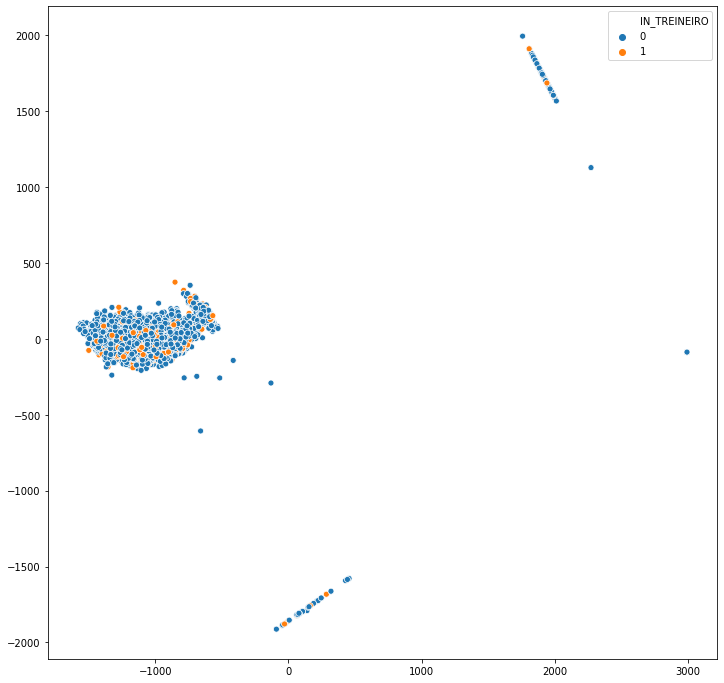

In [20]:
sns.scatterplot(X_train_pca[:, 0], X_train_pca[:, 1], hue=Y_train);

Nota-se uma maioria sendo da classe azul (0).
Pode-se utilizar o SMOTE (do pacote imblearn) para reamostrar os dados da classe minoritária e assim balancear o data set:

In [21]:
smote = SMOTE(sampling_strategy="minority")

X_smote, Y_smote = smote.fit_resample(X_train, Y_train)

In [22]:
X_train_pca_smote = pca.transform(X_smote)

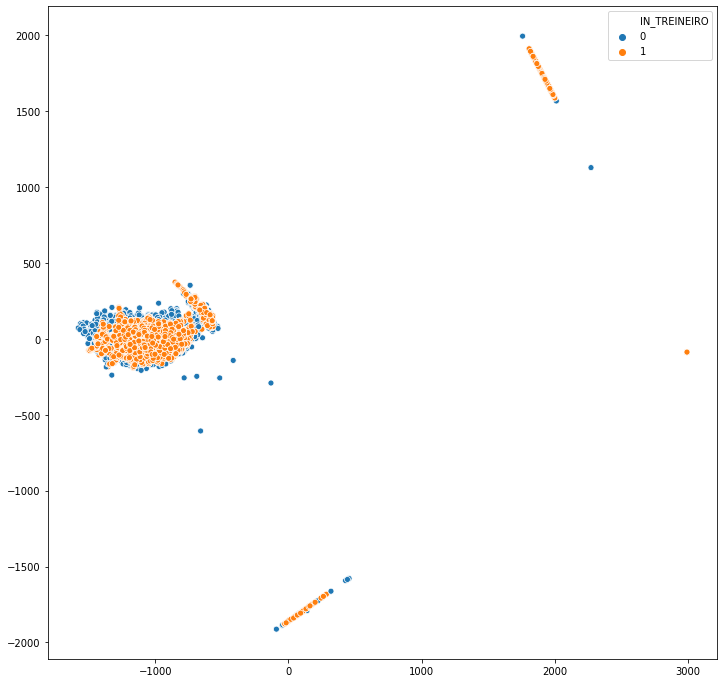

In [23]:
sns.scatterplot(x=X_train_pca_smote[:, 0], y=X_train_pca_smote[:, 1], hue=Y_smote);

In [24]:
# Verificação da proporção de valores
sum(Y_smote == 0)/sum(Y_smote == 1)

1.0

In [25]:
# Definindo o X test com a transformação PCA
X_test_pca = pca.transform(data_test.drop('IN_TREINEIRO', axis=1))

# Tentativa com Árvore de decisão

In [26]:
# Definindo a Árvore de decisão
decision_tree = DecisionTreeClassifier(max_depth=2)

In [27]:
# Realizando o Fit
decision_tree_fitted = decision_tree.fit(X_train_pca_smote, Y_smote)

In [28]:
# Realizando a predição
Y_pred_decision_tree = decision_tree.predict(X_test_pca)

In [29]:
# Salvando os resultados no arquivo answer.csv
#answer['IN_TREINEIRO'] = Y_pred_decision_tree
#answer.to_csv('answer.csv', encoding='utf-8', index=False) 

### Nota obtida no teste da Codenation: 97.92

# Tentativa com Regressão Logística

In [30]:
# Definindo a Regressão Logística
logistic = LogisticRegression()

In [31]:
# Realizando o Fit
logistic.fit(X_train_pca_smote, Y_smote)

c:\users\bruno\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
# Realizando a predição
Y_pred_logistic = logistic.predict(X_test_pca)

In [33]:
# Salvando os resultados no arquivo answer.csv
#answer['IN_TREINEIRO'] = Y_pred_logistic
#answer.to_csv('answer.csv', encoding='utf-8', index=False) 

### Nota obtida no teste da Codenation: 46.06

### Nota obtida no teste da Codenation: 94.92 (Quando faz fillna nos valores faltantes com 0 ao invés de -1000)

# Tentativa com Random Forest

In [34]:
# Definindo o Random Forest
random_forest = RandomForestClassifier(n_estimators=500)

In [35]:
# Realizando o Fit
random_forest_fitted = random_forest.fit(X_train_pca_smote, Y_smote)

In [36]:
# Realizando a predição
Y_pred_random_forest = random_forest.predict(X_test_pca)

In [37]:
# Salvando os resultados no arquivo answer.csv
answer['IN_TREINEIRO'] = Y_pred_random_forest
answer.to_csv('answer.csv', encoding='utf-8', index=False) 

### Nota obtida no teste da Codenation: 99.49

# Tentativa com Bagging

In [38]:
# Definindo o Bagging
bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=300, max_samples=100, bootstrap=True)

In [39]:
# Realizando o Fit
bagging_fitted = bagging.fit(X_train_pca_smote, Y_smote)

In [40]:
# Realizando a predição
Y_pred_bagging = bagging.predict(X_test_pca)

In [41]:
# Salvando os resultados no arquivo answer.csv
#answer['IN_TREINEIRO'] = Y_pred_bagging
#answer.to_csv('answer.csv', encoding='utf-8', index=False) 

### Nota obtida no teste da Codenation: 97.65

## Conclusão

Dentre os testes realizados, os melhores resultados foram obtidos utilizando o modelo de Random Forest para classificação. Além disso, utilizou-se a transformação PCA com 25 componentes e o método SMOTE para realizar uma reamostragem dos dados, que estavam desbalanceados. Para este, optou-se por reamostrar os dados da classe minoritária.

O trabalho com os dados faltantes é outro detalhe da modelagem que pode ser enfatizado. Embora foram encontrados melhores resultados para a regressão logística substituindo os dados de notas faltantes por Zero, para os outros modelos foram encontrados bons resultados de classificação substituindo a nota faltante por -1000. Esse valor é adotado por ser uma nota inatingível no exame do ENEM.